In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\vnuretdi\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Load the data

In [3]:
train = pd.read_csv('training.csv')
test=pd.read_csv('test.csv')

In [4]:
ids=pd.read_csv("IdLookupTable.csv")

In [5]:
sample=pd.read_csv("SampleSubmission.csv")

### Explore the images to choose the model

In [5]:
train.loc[590].index[:-1]

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [6]:
def getimage(k):
    a=[int(i) for i in train['Image'][k].split(' ')]
    a=[aa/255 for aa in a]
    a=np.reshape(a,(96,96))
    plt.imshow(a)
    for i in range(int((len(train.loc[k])-1)/2)):
        check=train.loc[k]
        plt.scatter(check[i*2], check[1+i*2], s=5, c='red', marker='o')
    plt.show()

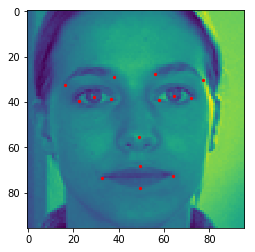

In [328]:
getimage(590)


#### Using the example of the right eye I want to think on possible features which might identify the points position

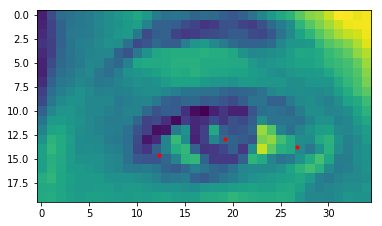

In [288]:
k=590
a=[int(i) for i in train['Image'][k].split(' ')]
a=[aa/255 for aa in a]
a=np.reshape(a,(96,96))
## x and y coordinates are reversed in np.reshape
plt.imshow(a[25:45,10:45])
for i in [1,4,5]:
        check=train.loc[k]
        plt.scatter(check[i*2]-10, check[1+i*2]-25, s=10, c='red', marker='o')
plt.show()

In [291]:
train.iloc[k][2:4]

right_eye_center_x     29.223
right_eye_center_y    37.9039
Name: 590, dtype: object

In [292]:
train.iloc[k][8:12]

right_eye_inner_corner_x    36.6968
right_eye_inner_corner_y    38.7345
right_eye_outer_corner_x    22.3036
right_eye_outer_corner_y    39.5644
Name: 590, dtype: object

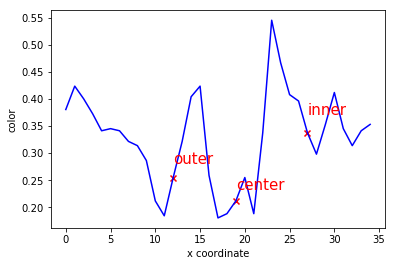

In [295]:
plt.plot(a[39,10:45], c='blue')

plt.scatter(12, a[39, 22], c='red', marker='x')
plt.annotate("outer", xy=(12, a[39, 22]*1.1), color='red', fontsize=15)

plt.scatter(27, a[39, 37], c='red', marker='x')
plt.annotate("inner", xy=(27, a[39, 37]*1.1), color='red', fontsize=15)

plt.scatter(19, a[39, 29], c='red', marker='x')
plt.annotate("center", xy=(19, a[39, 29]*1.1), color='red', fontsize=15)
plt.xlabel("x coordinate")
plt.ylabel("color")
plt.show()

I can see that you can identify the points based on color changes, they're close to the color borders. Eg outer eye corner starts where darker color (skin) changes to lighter color (eye ball).
Other important parameters are absolute position, eg you expect the right eye outter corner to be in the upper left part of the picture.
Therefore, I'm going to build my model based on:
- x position
- y position
- color change in x coordinate
- color change in y coordinate
- absolute color value in the point

### Transform the data for the model

#### Reshape train and test data

In [7]:
train_data=[]

In [8]:
for x in train['Image']:
    a=[int(i) for i in x.split(' ')]
    a=[aa/255 for aa in a]
    train_data.append(np.reshape(a,(96,96)))

In [83]:
test_data=[]

In [84]:
for x in test['Image']:
    a=[int(i) for i in x.split(' ')]
    a=[aa/255 for aa in a]
    test_data.append(np.reshape(a,(96,96)))

## Create dataset to test the model (flipped incomplete data)

In [6]:
from copy import copy, deepcopy

incomplete=train[train.isnull().any(axis=1)]
image_incomp=incomplete['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
X_incomp=np.vstack(image_incomp.values) / 255
X_incomp = X_incomp.astype(np.float64)

X1_incomp=deepcopy(X_incomp)

for i in range(len(X1_incomp)):
    a1=np.reshape(X1_incomp[i],(96,96))
    a1=np.flip(a1, 1)
    a1=np.reshape(a1,(96*96))
    X1_incomp[i]=a1

#return initial incomplete data
Y_incomp=incomplete.drop(['Image'], axis=1).values
Y_incomp=(Y_incomp-48)/48
Y_incomp=Y_incomp.astype(np.float64)
Y1_incomp=deepcopy(Y_incomp)

for i in range(len(Y1_incomp)):
    Y1_incomp[i][0::2]=-Y1_incomp[i][0::2]
    Y1_incomp[i]=Y1_incomp[i][[2,3,0,1,8,9,10,11,4,5,6,7,16,17,18,19,12,13,14,15,20,21,24,25,22,23,26,27,28,29]]

X1_incomp.shape

(4909, 9216)

In [115]:
check_data=[np.reshape(x1,(96,96)) for x1 in X1_incomp]

#### Choose image pieces relevant to each face point

In [90]:
pieces=pd.DataFrame(columns=["min","max"])

In [91]:
# 5% and 95% quantiles for each facepoint based on the train samples

for x in train.columns[:-1]:
    pieces.loc[x,"min"]=max(np.nanpercentile(train[x], 5)-3,0)
    pieces.loc[x,"max"]=min(np.nanpercentile(train[x], 95)+3,95)
 #   print(x, np.nanmedian(train[x]), np.nanpercentile(train[x], 5), np.nanpercentile(train[x], 95), np.min(train[x]), np.max(train[x]))

In [92]:
pieces

,min,max
left_eye_center_x,59.2235,73.6583
left_eye_center_y,30.2259,45.4022
right_eye_center_x,23.3329,37.6572
right_eye_center_y,30.788,45.2941
left_eye_inner_corner_x,52.7534,65.3329
left_eye_inner_corner_y,31.6134,44.1399
left_eye_outer_corner_x,66.2445,81.1165
left_eye_outer_corner_y,30.2089,44.9072
right_eye_inner_corner_x,30.577,42.6246
right_eye_inner_corner_y,31.5141,44.2578


In [368]:
#### Transform the table with coordinates into more compact form

In [93]:
### names of the variables
names=[]
for x in train.columns[:-1]:
    names.append(str(x)[:-2])
names=list(set(names))

In [94]:
names

['left_eyebrow_outer_end',
 'left_eyebrow_inner_end',
 'right_eyebrow_outer_end',
 'mouth_center_bottom_lip',
 'right_eye_inner_corner',
 'left_eye_center',
 'right_eye_outer_corner',
 'right_eye_center',
 'right_eyebrow_inner_end',
 'left_eye_inner_corner',
 'mouth_center_top_lip',
 'nose_tip',
 'mouth_right_corner',
 'left_eye_outer_corner',
 'mouth_left_corner']

In [95]:
coordinates=pd.DataFrame(columns=["min_x","max_x","min_y","max_y"])

In [96]:
for x in names:
    a=np.where(pieces.index.str.contains(x))[0]
    coordinates.loc[x,"min_x"]=pieces.iloc[a[0],0]
    coordinates.loc[x,"max_x"]=pieces.iloc[a[0],1]
    coordinates.loc[x,"min_y"]=pieces.iloc[a[1],0]
    coordinates.loc[x,"max_y"]=pieces.iloc[a[1],1]
coordinates=coordinates.astype(int)

In [ ]:
names_match=[]

### Preprocess train and test input into Features matrix and train the model

- Features are x-coordinate, y-coordinate, x-delta: change in x coordinate, y-delta: change in y coordinate (0 - no change in the color direction, 1- change in the color direction)
- Target values are 0 for non-key facepoints and 1 for key facepoints
- I think that random forest is the relevant model for such feature and output type. I need to find out which features and what value determine high probability of the key facepoint

In [34]:
train_all=pd.DataFrame(columns=["facepoint", "image", "x_index","y_index","x_delta","y_delta",\
                               "x_bigdelta","y_bigdelta", "x_change","y_change","value","target"])

In [35]:
test_all=pd.DataFrame(columns=["facepoint", "image", "x_index","y_index","x_delta","y_delta",\
                               "x_bigdelta","y_bigdelta", "x_change","y_change","value"])

In [36]:
check_all=pd.DataFrame(columns=["facepoint", "image", "x_index","y_index","x_delta","y_delta",\
                               "x_bigdelta","y_bigdelta", "x_change","y_change","value"])

In [37]:
def rf_calc(test_data, test_all, model):
    test_df=pd.DataFrame(columns=["facepoint", "image", "x_index","y_index", "x_bigdelta","y_bigdelta", \
                                  "x_change","y_change","x_delta","y_delta", "value"])
    
    test_data_r=[x[a3:a4] for x in test_data]
    test_data_r=[[k[a1:a2] for k in x] for x in test_data_r]
    test_data_r=[np.concatenate(x, axis=0) for x in test_data_r]

    values=np.concatenate(test_data_r, axis=0)
    x_change=[int((x[a3+i][a1+j-1]-x[a3+i][a1+j])*(x[a3+i][a1+j]-x[a3+i][a1+j+1])>=0) for i in range(a4-a3)\
              for j in range(a2-a1) for x in test_data]
    y_change=[int((x[a3+i-1][a1+j]-x[a3+i][a1+j])*(x[a3+i][a1+j]-x[a3+i+1][a1+j])>=0) for i in range(a4-a3)\
              for j in range(a2-a1) for x in test_data]
    x_delta=[x[a3+i][a1+j-1]-x[a3+i][a1+j+1] for i in range(a4-a3)\
              for j in range(a2-a1) for x in test_data]
    y_delta=[x[a3+i-1][a1+j]-x[a3+i+1][a1+j] for i in range(a4-a3)\
              for j in range(a2-a1) for x in test_data]
    x_bigdelta=[x[a3+i][max(0,a1+j-2)]-x[a3+i][min(96,a1+j+2)] for i in range(a4-a3)\
          for j in range(a2-a1) for x in test_data]
    y_bigdelta=[x[max(0,a3+i-2)][a1+j]-x[min(0,a3+i+2)][a1+j] for i in range(a4-a3)\
          for j in range(a2-a1) for x in test_data]
    
    test_df.x_delta=pd.Series(x_delta)
    test_df.y_delta=pd.Series(y_delta)
    test_df.x_bigdelta=pd.Series(x_bigdelta)
    test_df.y_bigdelta=pd.Series(y_bigdelta)
    test_df.x_change=pd.Series(x_change)
    test_df.y_change=pd.Series(y_change)
    test_df.facepoint=f
    test_df.value=pd.Series(values)
    test_df.image=np.concatenate([[x]*(a4-a3)*(a2-a1) for x in range(len(test_data))], axis=0)
    test_df.x_index=pd.Series(list(range(a2-a1))*(a4-a3)*len(test_data))
    test_df.y_index=pd.Series(np.concatenate([[k]*(a2-a1) for k in range(a4-a3)]*len(test_data)))
    
    rf_preds=model.predict(test_df[predictors])
    
    #record the results of rf prediction
    test_df['rf_preds']=rf_preds
    
    test_len=len(set(test_df.image))
    
    idx=[]
    for k in range(test_len):
        subset=test_df[(test_df.image==k)]
        a=subset['rf_preds'].idxmax(axis=0, skipna=True)
        idx.append(a)
        
    test_df['preds']=0
    test_df['preds'][idx]=1
    
    #print("sum", np.sum(test_df['preds'][idx]))
    print(test_df.shape)         
          
    test_all=test_all.append(test_df)  
    #print("test_all", test_all.shape) 
    
    return test_all

In [ ]:
# Transform the images into dataset of features and apply RF method to it

for f in names:
    
    train_df=pd.DataFrame(columns=["facepoint", "image", "x_index","y_index","x_delta","y_delta",\
                               "x_bigdelta","y_bigdelta","x_change","y_change","value","target"])
    a1=coordinates.loc[f][0]
    a2=coordinates.loc[f][1]
    a3=coordinates.loc[f][2]
    a4=coordinates.loc[f][3]
    
    #take reduced data
    train_data_r=[x[a3:a4] for x in train_data]
    train_data_r=[[k[a1:a2] for k in x] for x in train_data_r]
    train_data_r=[np.concatenate(x, axis=0) for x in train_data_r]
    
    values=np.concatenate(train_data_r, axis=0)
    x_change=[int((x[a3+i][a1+j-1]-x[a3+i][a1+j])*(x[a3+i][a1+j]-x[a3+i][a1+j+1])>=0) for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    y_change=[int((x[a3+i-1][a1+j]-x[a3+i][a1+j])*(x[a3+i][a1+j]-x[a3+i+1][a1+j])>=0) for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    x_delta=[x[a3+i][a1+j-1]-x[a3+i][a1+j+1] for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    y_delta=[x[a3+i-1][a1+j]-x[a3+i+1][a1+j] for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    x_bigdelta=[x[a3+i][max(0,a1+j-2)]-x[a3+i][min(96,a1+j+2)] for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    y_bigdelta=[x[max(0,a3+i-2)][a1+j]-x[min(0,a3+i+2)][a1+j] for i in range(a4-a3)\
          for j in range(a2-a1) for x in train_data]
    
    train_df.x_change=pd.Series(x_change)
    train_df.y_change=pd.Series(y_change)
    train_df.x_delta=pd.Series(x_delta)
    train_df.y_delta=pd.Series(y_delta)
    train_df.x_bigdelta=pd.Series(x_bigdelta)
    train_df.y_bigdelta=pd.Series(y_bigdelta)
    train_df.facepoint=f
    train_df.value=pd.Series(values)
    train_df.image=np.concatenate([[x]*(a4-a3)*(a2-a1) for x in range(len(train_data))], axis=0)
    train_df.x_index=pd.Series(list(range(a2-a1))*(a4-a3)*len(train_data))
    train_df.y_index=pd.Series(np.concatenate([[k]*(a2-a1) for k in range(a4-a3)]*len(train_data)))
    
    #populate train target with 0 and 1
    train_df.target=0
    ind=[]
    nas=[]
    out=[]
    for k in range(len(train_data)):
        check=train.loc[k][np.where(pieces.index.str.contains(f))[0]]
        a=k*(a4-a3)*(a2-a1)+(a2-a1)*np.round(check[1]-a3)+np.round(check[0]-a1)        
        if np.isnan(a):
            nas.append(int(k))
        elif ~(a3<check[1]<a4)&(a1<check[0]<a2):
            out.append(int(k))
        else:
            ind.append(int(a))         
            
            
    #print("ind", len(ind), "out", len(out), "nas", len(nas))
    train_df.loc[ind,"target"]=1    
    train_df=train_df[~train_df.image.isin(nas)]
    
    train_all=train_all.append(train_df)
    
    predictors=["x_index","y_index","x_change","y_change","value","x_delta","y_delta", "x_bigdelta","y_bigdelta"]
    rf = RandomForestRegressor(n_estimators=50, oob_score=True) 
    rf.fit(train_df[predictors], train_df.target)   
   

In [ ]:
#calculate test and dev data based on resulting RF model 
test_all=rf_calc(test_data, test_all, rf)
check_all=rf_calc(check_data, check_all, rf)

In [322]:
train_all.shape

(15687352, 12)

In [39]:
train_all.to_csv("train_all.csv")
test_all.to_csv("test_all.csv")
check_all.to_csv("check_all.csv")

In [235]:
check_result.to_csv("check_result.csv")

In [300]:
train_all=pd.read_csv("train_all.csv", index_col=None)

In [310]:
train_all= train_all.drop('Unnamed: 0', axis=1)

In [313]:
train_all.drop(["x_bigdelta",'y_bigdelta'], axis=1).head()

,facepoint,image,x_index,y_index,x_delta,y_delta,x_change,y_change,value,target
0,left_eye_inner_corner,0,0,0,0.031373,0.031373,1,1,0.521569,0
1,left_eye_inner_corner,0,1,0,0.117647,0.074510,1,1,0.498039,0
2,left_eye_inner_corner,0,2,0,0.019608,-0.011765,1,1,0.454902,0
3,left_eye_inner_corner,0,3,0,-0.023529,0.031373,1,1,0.435294,0
4,left_eye_inner_corner,0,4,0,-0.015686,-0.066667,1,1,0.435294,0


#### Create the submission file based on the RF model prediction results

In [ ]:
test_result=test_all[["facepoint","image","preds","x_index","y_index"]]
test_result=test_result[test_result.preds==1]

In [ ]:
ids.ImageId-=1
ids.index=ids.ImageId

In [ ]:
for f in names:
    result=test_result[test_result.facepoint==f]
    result.index=result.image
    result.x_index+=coordinates.loc[f][0]
    result.y_index+=coordinates.loc[f][2]
    
    index=list(ids[ids.FeatureName==str(f+"_x")].ImageId)
    ids.loc[ids.FeatureName==str(f+"_x"),"Location"]=result.loc[index,"x_index"]
    
    index=list(ids[ids.FeatureName==str(f+"_y")].ImageId)
    ids.loc[ids.FeatureName==str(f+"_y"),"Location"]=result.loc[index,"y_index"]  

In [305]:
submission=ids[["RowId","Location"]]

In [306]:
submission.to_csv("submission.csv", index=False)

## Test the model performance on dev data

In [286]:
check_result=check_all[["facepoint","image","preds","x_index","y_index"]]
check_result=check_result[check_result.preds==1]

In [287]:
# match the index of facepoint values to check_data columns
names_ind=[train.loc[0].index[:-1].values][0]
names_match={key:0 for key in names}
for f in names:
    names_match[f]=[i for i in range(len(names_ind)) if names_ind[i].startswith(f)][0]

In [317]:
# adjust the calculated values to coordinates minimum to compare them with reach values
for f in names:
    check_result.loc[check_result.facepoint==f, 'x_index']+=coordinates.loc[f][0]
    check_result.loc[check_result.facepoint==f, 'y_index']+=coordinates.loc[f][2]

In [318]:
# add real values
for f in names:
    for i in range(len(Y1_incomp)):
        ind=check_result.loc[(check_result.image==i)&(check_result.facepoint==f)].index
        check_result.loc[ind, "x_real"]=Y1_incomp[i][names_match[f]]
        check_result.loc[ind, "y_real"]=Y1_incomp[i][names_match[f]+1]

In [319]:
# denormalize the real values
check_result['x_real']=(check_result['x_real']+1)*48
check_result['y_real']=(check_result['y_real']+1)*48

In [336]:
# Calculate RMSE
((np.nansum(((check_result.x_real-check_result.x_index))**2)+\
np.nansum(((check_result.y_real-check_result.y_index))**2))/(2*np.sum(np.isnan(check_result.x_real))))**0.5

3.5750104665396956

### Review a few test pictures

The points are not too much off for majority of pictures, but far from being exact, especially for lips and nose. Performance for eyes is better.

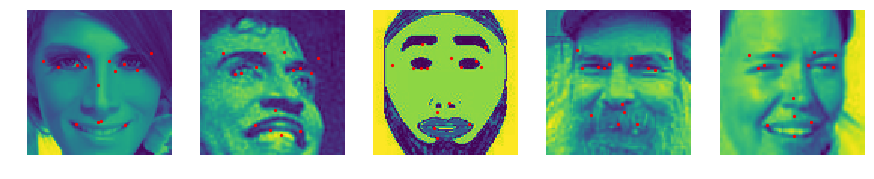

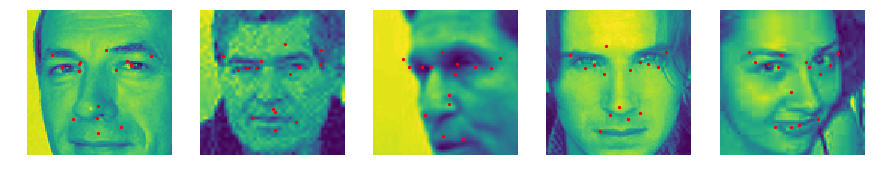

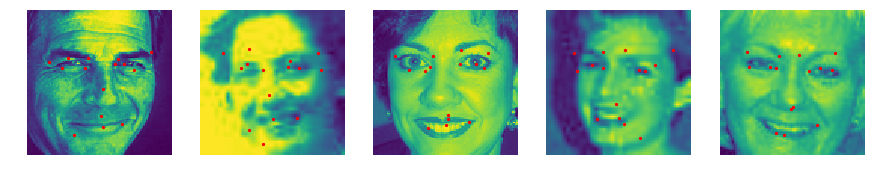

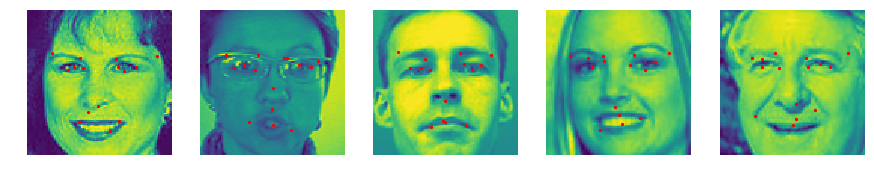

In [112]:
ind=(list(np.random.choice(range(len(test_data)),20)))

for i in range(4): 
    fig, ax = plt.subplots(1,5, figsize=(15,3))  
    
    for j, k in enumerate(ind[i*5:(i*5+5)]):
        a=test_data[k]
        ax[j].axis('off') 
        ax[j].imshow(a)
        points=test_all[(test_all.image==k)&(test_all.preds==1)]
        for f in names:
            point=points[points.facepoint==f]
            ax[j].scatter(point.x_index+coordinates.loc[f][0], point.y_index+coordinates.loc[f][2], s=5, c='red', marker='o')
    plt.show()

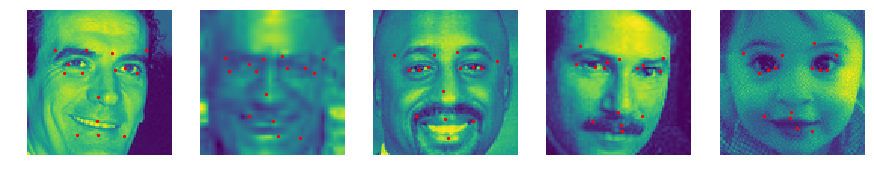

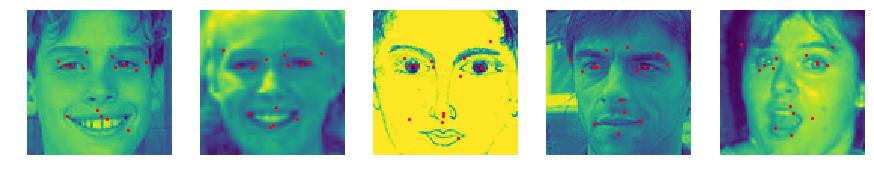

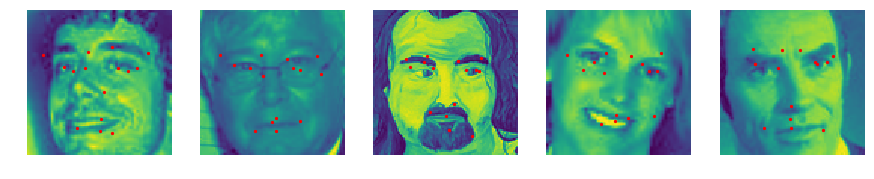

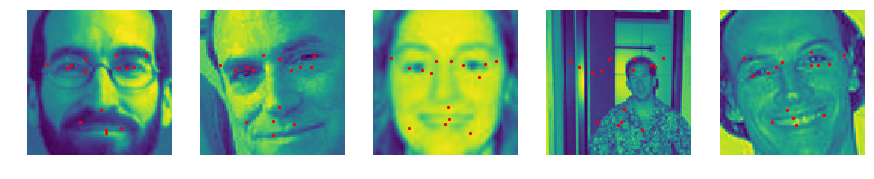

In [117]:
ind=(list(np.random.choice(range(len(check_data)),20)))

for i in range(4): 
    fig, ax = plt.subplots(1,5, figsize=(15,3))  
    
    for j, k in enumerate(ind[i*5:(i*5+5)]):
        a=check_data[k]
        ax[j].axis('off') 
        ax[j].imshow(a)
        points=check_all[(check_all.image==k)&(check_all.preds==1)]
        for f in names:
            point=points[points.facepoint==f]
            ax[j].scatter(point.x_index+coordinates.loc[f][0], point.y_index+coordinates.loc[f][2], s=5, c='red', marker='o')
    plt.show()

In [ ]:
ind=(list(np.random.choice(range(len(test_data)),20)))

for i in range(4): 
    fig, ax = plt.subplots(1,5, figsize=(15,3))  
    
    for j, k in enumerate(ind[i*5:(i*5+5)]):
        a=train_data[k]
        ax[j].axis('off') 
        ax[j].imshow(a)
        points=test_all[(test_all.image==k)&(test_all.preds==1)]
        for f in names:
            point=points[points.facepoint==f]
            ax[j].scatter(point.x_index+coordinates.loc[f][0], point.y_index+coordinates.loc[f][2], s=5, c='red', marker='o')
    plt.show()